# Data Pipeline

ah shit, 
here we go again
{insert cj meme here}

In [1]:
from _Setup import *

In [2]:
train_data = pd.read_csv(rawTrainFile)
test_data = pd.read_csv(rawTestFile)

C:\Users\Trevo\AppData\Local\Temp\ipykernel_57764\3702163432.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  test_data = pd.read_csv(rawTestFile)


# Train data preparation

In [3]:
# backward fill function
def backward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .bfill()
    )

    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

In [4]:
def forward_fill_by_patient(df, patient_id_col='patient'):
    # Create a copy of the original DataFrame
    df_imputed = df.copy()

    df_imputed.loc[:, df_imputed.columns != patient_id_col] = (
        df_imputed.groupby(patient_id_col)
        .ffill()
    )
    
    # If there are patients with no entries for a column, those columns will remain unchanged
    return df_imputed

## Remove Columns w/ > 95% initial missing values and B/F imputation

In [5]:
# Identify columns with more than 90% missing values

missing_percentage = train_data.isnull().mean() * 100

cols_to_drop_for_missing_percentage = missing_percentage[missing_percentage > 95].index

# Drop the identified columns

train_truncated = train_data.drop(columns=cols_to_drop_for_missing_percentage)

In [6]:
#forward imputation
train_forward = forward_fill_by_patient(train_truncated)
train_forward.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,NaN,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [7]:
#backward imputation
pre_imputed_train = backward_fill_by_patient(train_forward)
pre_imputed_train.head()  

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0.0,1.0,-4.25,5.0,0.0


In [8]:
# Identify columns with more than 90% missing values

missing_percentage = pre_imputed_train.isnull().mean() * 100

cols_to_drop_for_missing_percentage2 = missing_percentage[missing_percentage > 80].index

print(cols_to_drop_for_missing_percentage2)

Index([], dtype='object')


## MissForest imputation

In [9]:
naPercentages = pd.DataFrame(pre_imputed_train.isna().sum() / pre_imputed_train.shape[0], columns=['Percentage'])
naPercentages.sort_values(by = ['Percentage'], ascending=False)           

,Percentage
BaseExcess,0.637390
FiO2,0.501017
PaCO2,0.485635
pH,0.471871
Unit1,0.391502
Unit2,0.391502
DBP,0.166844
Calcium,0.096244
Magnesium,0.087443
WBC,0.041200


# NOTE :
This needs python 3.12 to get the .fit and .transforms funcitons on the MissForest imputer

In [10]:
imputer = MissForest()

imputer_input = pre_imputed_train.drop('SepsisLabel', axis = 1)
imputed_data = imputer.fit_transform(imputer_input)

imputed_data['SepsisLabel'] = pre_imputed_train['SepsisLabel']

imputed_data.isna().sum()

100%|██████████| 5/5 [14:19<00:00, 171.82s/it]


patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
dtype: int64

## Fixing uni1 and unit2 problem

In [11]:
# Convert to binary values
imputed_data['Unit1'] = imputed_data['Unit1'].apply(lambda x: 1 if x >= 0.5 else 0)
imputed_data['Unit2'] = imputed_data['Unit2'].apply(lambda x: 1 if x >= 0.5 else 0)

# Print the unique values again to verify
print("Unique values in Unit1 after transformation:")
print(imputed_data['Unit1'].unique())

print("\nUnique values in Unit2 after transformation:")
print(imputed_data['Unit2'].unique())


Unique values in Unit1 after transformation:
[0 1]

Unique values in Unit2 after transformation:
[1 0]


# Workflow:

1. Train/Validation Split
2. SMOTE Train dataset by sample point

--- Separate Files Here ---

3. Build Models
4. Evaluate Performance

--- Create Separate file to do this ---

5. Rebuild Best model using complete original data



# TODO : Train/Validation Split

In [12]:
# Create variable to see if patient ever has sepsis
imputed_data['SepsisPatient'] = imputed_data.groupby('patient')['SepsisLabel'].transform(lambda x: 1 if (x == 1).any() else 0)


# Create create [patient, SepsisEver] pair to take stratified sample
patientsList = imputed_data.drop_duplicates(subset=['patient', 'SepsisPatient'])[['patient', 'SepsisPatient']]

X_sample = patientsList['patient']
y_sample =  patientsList['SepsisPatient']

# Take stratified sample based upon whether individual ever has Sepsis
patient_labels_train, patient_labels_validate, _, _ = train_test_split(X_sample, y_sample, test_size=0.2, stratify=y_sample)


In [13]:
# Reexpand Train Data
train_split_data = imputed_data[imputed_data['patient'].isin(patient_labels_train)].drop('SepsisPatient', axis = 1)
validate_split_data = imputed_data[imputed_data['patient'].isin(patient_labels_validate)].drop('SepsisPatient', axis = 1)
validate_split_data.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
43,16371,1,90.0,93.0,36.9,120.0,85.0,70.0,18.0,0.017245,...,11.8,8.5,216.0,67.0,1.0,0,1,-42.19,1.0,0.0
44,16371,2,90.0,93.0,36.9,120.0,85.0,70.0,18.0,0.017245,...,11.8,8.5,216.0,67.0,1.0,0,1,-42.19,2.0,0.0
45,16371,3,95.0,94.0,36.9,108.5,78.5,68.0,17.5,0.017245,...,11.8,8.5,216.0,67.0,1.0,0,1,-42.19,3.0,0.0
46,16371,4,96.0,96.0,36.9,117.0,83.0,73.5,16.5,0.017245,...,11.8,8.5,216.0,67.0,1.0,0,1,-42.19,4.0,0.0
47,16371,5,97.0,95.0,36.9,118.0,81.0,71.0,15.0,0.017245,...,11.8,8.5,216.0,67.0,1.0,0,1,-42.19,5.0,0.0


In [ ]:
# TODO : Put tail function in here

# SMOTE

In [15]:

X = train_split_data.drop('SepsisLabel', axis = 1)
y = train_split_data['SepsisLabel']

# TODO : Tune this

sm = SMOTE(sampling_strategy=0.4, k_neighbors=5, random_state=8)
X_train_syn, y_train_syn = sm.fit_resample(X, y)

print(imputed_data.iloc[:, 0:4].describe())
print(X_train_syn.iloc[:, 0:4].describe())

            patient          time            HR         O2Sat
count  1.088197e+06  1.088197e+06  1.088197e+06  1.088197e+06
mean   1.410742e+04  2.668297e+01  8.438115e+01  9.715170e+01
std    8.151722e+03  2.955474e+01  1.742592e+01  3.140354e+00
min    1.000000e+00  1.000000e+00  2.000000e+01  2.000000e+01
25%    7.043000e+03  1.000000e+01  7.200000e+01  9.600000e+01
50%    1.410100e+04  2.000000e+01  8.300000e+01  9.800000e+01
75%    2.118100e+04  3.400000e+01  9.500000e+01  9.900000e+01
max    2.823500e+04  4.250000e+02  2.110000e+02  1.001495e+02
            patient          time            HR         O2Sat
count  1.195994e+06  1.195994e+06  1.195994e+06  1.195994e+06
mean   1.415142e+04  3.422218e+01  8.609057e+01  9.710881e+01
std    8.155592e+03  4.155298e+01  1.800774e+01  3.216848e+00
min    2.000000e+00  1.000000e+00  2.000000e+01  2.000000e+01
25%    7.093000e+03  1.000000e+01  7.300000e+01  9.600000e+01
50%    1.420600e+04  2.200000e+01  8.500000e+01  9.800000e+01
75%    2

In [16]:
resampled_train = pd.concat([X_train_syn, y_train_syn], axis = 1)
resampled_train.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,16426,1,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0,1,-4.25,1.0,0.0
1,16426,2,78.0,99.5,35.25,108.5,84.5,69.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0,1,-4.25,2.0,0.0
2,16426,3,80.0,99.0,36.20,113.0,87.0,73.0,12.0,0.0,...,12.0,14.2,162.0,57.03,1.0,0,1,-4.25,3.0,0.0
3,16426,4,79.0,100.0,36.50,112.0,83.0,68.0,12.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0,1,-4.25,4.0,0.0
4,16426,5,73.0,100.0,36.50,115.0,80.0,64.0,11.0,-2.5,...,12.0,14.2,162.0,57.03,1.0,0,1,-4.25,5.0,0.0


In [17]:
# Before smote distribution 
sepsis_inf = train_data['SepsisLabel'].value_counts()
sepsis_percentages = (sepsis_inf / sepsis_inf.sum()) * 100
print(sepsis_percentages)

SepsisLabel
0.0    98.196924
1.0     1.803076
Name: count, dtype: float64


In [18]:
# After smote distribution
sepsis_inf2 = resampled_train['SepsisLabel'].value_counts()
sepsis_percentages2 = (sepsis_inf2 / sepsis_inf2.sum()) * 100
print(sepsis_percentages2)

SepsisLabel
0.0    71.428619
1.0    28.571381
Name: count, dtype: float64


In [19]:
resampled_train.isna().sum()

patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
dtype: int64

In [20]:
resampled_train.shape

(1195994, 30)

# Feature Engineering

In [21]:
def FeatureEngineering(df):
    df['Shock'] = df['HR'] / (df['SBP'] + 0.0000001)
    
    # Check if Fever is higher than 38 or lower than 36 at that point or after
    df['Fever'] = df.groupby('patient')['Temp'].transform(
        lambda x: (x < 36).cumsum() + (x > 38).cumsum() > 0
        ).astype(int)
    
    # Check for Tachycardis (HR > 90 BPM)
    df['TCA'] = df.groupby('patient')['HR'].transform(
        lambda x: (x > 90).cumsum() > 0
        ).astype(int)
    
    # Check for Tachypnea (Resp > 20 breaths per minute)
    df['TCP'] = df.groupby('patient')['Resp'].transform(
        lambda x: (x > 20).cumsum() > 0
        ).astype(int)
    
    # Check for Leukocytosis (WBC > 12000) or Leukopenimia (WBC < 4000)
    df['LEU'] = df.groupby('patient')['WBC'].transform(
        lambda x: (x < 4).cumsum() + (x > 12).cumsum() > 0
        ).astype(int)
    
    return df

In [22]:
featured_train = FeatureEngineering(resampled_train)
#featured_train = resampled_train
featured_train.isna().sum()

patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
SepsisLabel    0
Shock          0
Fever          0
TCA            0
TCP            0
LEU            0
dtype: int64

In [23]:
featured_train.SBP.describe()

count    1.195994e+06
mean     1.228135e+02
std      2.329498e+01
min      2.000000e+01
25%      1.060000e+02
50%      1.200000e+02
75%      1.377616e+02
max      3.000000e+02
Name: SBP, dtype: float64

## Scaling 

In [24]:
# NOTE : This code is not cleaned for SepsisLabel to ensure ease of use at the test step

exclude_scaling_cols = ['patient', 'Gender', 'Unit1', 'Unit2', 'Fever', 'TCP', 'TCA', 'LEU']

# Separate columns into those to scale and those to exclude
cols_to_scale = featured_train.drop(columns=exclude_scaling_cols + ['SepsisLabel']).columns
scaled_data = featured_train[cols_to_scale]

# Scale the selected columns
scaler = StandardScaler()
scaled_scaled_data = pd.DataFrame(scaler.fit_transform(scaled_data), columns=cols_to_scale)

# Combine scaled data with excluded columns and the target variable
scaled_train = pd.concat(
    [scaled_scaled_data, 
     featured_train[exclude_scaling_cols].reset_index(drop=True), 
     featured_train['SepsisLabel'].reset_index(drop=True)], 
    axis=1
)

# Display the resulting DataFrame
print(scaled_train.head())

       time        HR     O2Sat      Temp       SBP       MAP       DBP  \
0 -0.799514 -0.449283  0.743334 -2.128854 -0.614444  0.156049  0.427405   
1 -0.775449 -0.449283  0.743334 -2.128854 -0.614444  0.156049  0.427405   
2 -0.751383 -0.338220  0.587902 -0.930922 -0.421269  0.310043  0.723030   
3 -0.727317 -0.393751  0.898766 -0.552628 -0.464197  0.063652  0.353499   
4 -0.703251 -0.726942  0.898766 -0.552628 -0.335414 -0.121140  0.057875   

       Resp  BaseExcess      FiO2  ...     Shock  patient  Gender  Unit1  \
0 -1.296970    0.041034  0.067488  ... -0.042956    16426     1.0      0   
1 -1.296970    0.041034  0.067488  ... -0.042956    16426     1.0      0   
2 -1.296970    0.041034 -0.000373  ... -0.093116    16426     1.0      0   
3 -1.296970   -0.752669 -0.000373  ... -0.105082    16426     1.0      0   
4 -1.480397   -0.752669 -0.013946  ... -0.428978    16426     1.0      0   

   Unit2  Fever  TCP  TCA  LEU  SepsisLabel  
0      1      1    0    0    1          0.0  


In [25]:
featured_train.shape

(1195994, 35)

In [26]:
scaled_train.shape

(1195994, 35)

In [27]:
scaled_train.isna().count()

time           1195994
HR             1195994
O2Sat          1195994
Temp           1195994
SBP            1195994
MAP            1195994
DBP            1195994
Resp           1195994
BaseExcess     1195994
FiO2           1195994
pH             1195994
PaCO2          1195994
BUN            1195994
Calcium        1195994
Creatinine     1195994
Glucose        1195994
Magnesium      1195994
Potassium      1195994
Hct            1195994
Hgb            1195994
WBC            1195994
Platelets      1195994
Age            1195994
HospAdmTime    1195994
ICULOS         1195994
Shock          1195994
patient        1195994
Gender         1195994
Unit1          1195994
Unit2          1195994
Fever          1195994
TCP            1195994
TCA            1195994
LEU            1195994
SepsisLabel    1195994
dtype: int64

## Correlation Matrixes for train data set pipeline

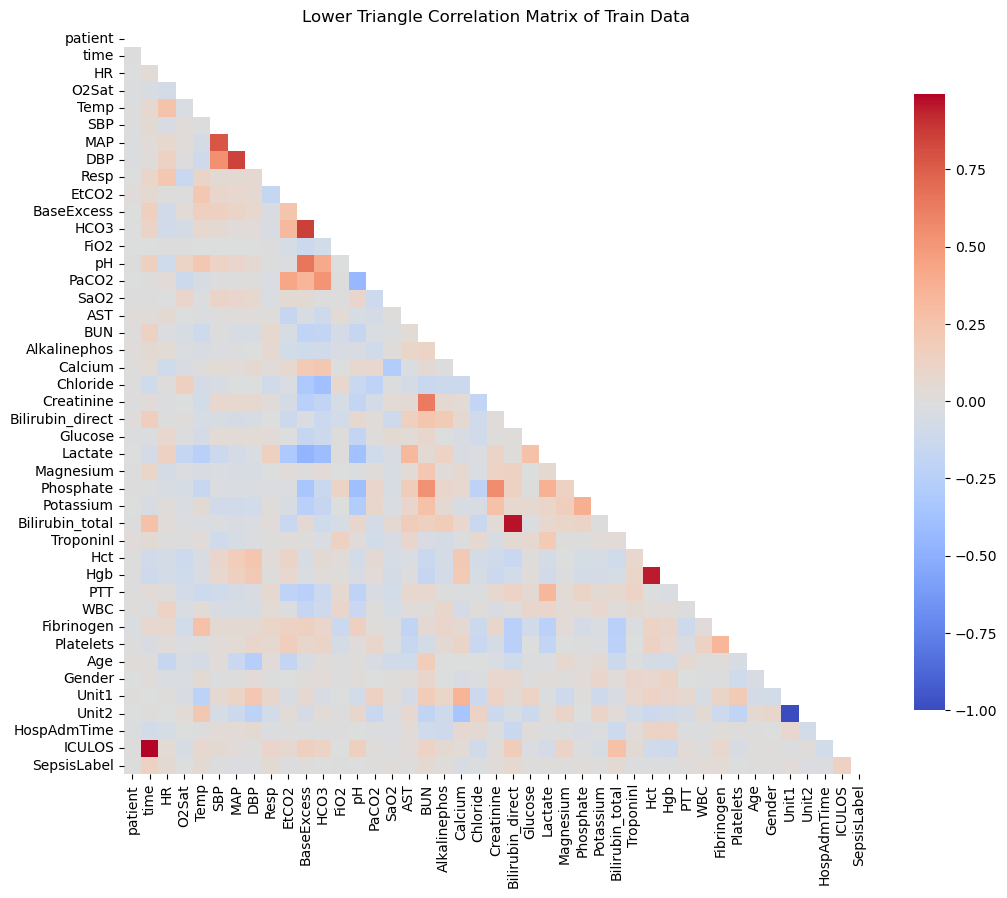

In [28]:
# TODO : Move this to the top of the file

correlation_matrix = train_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

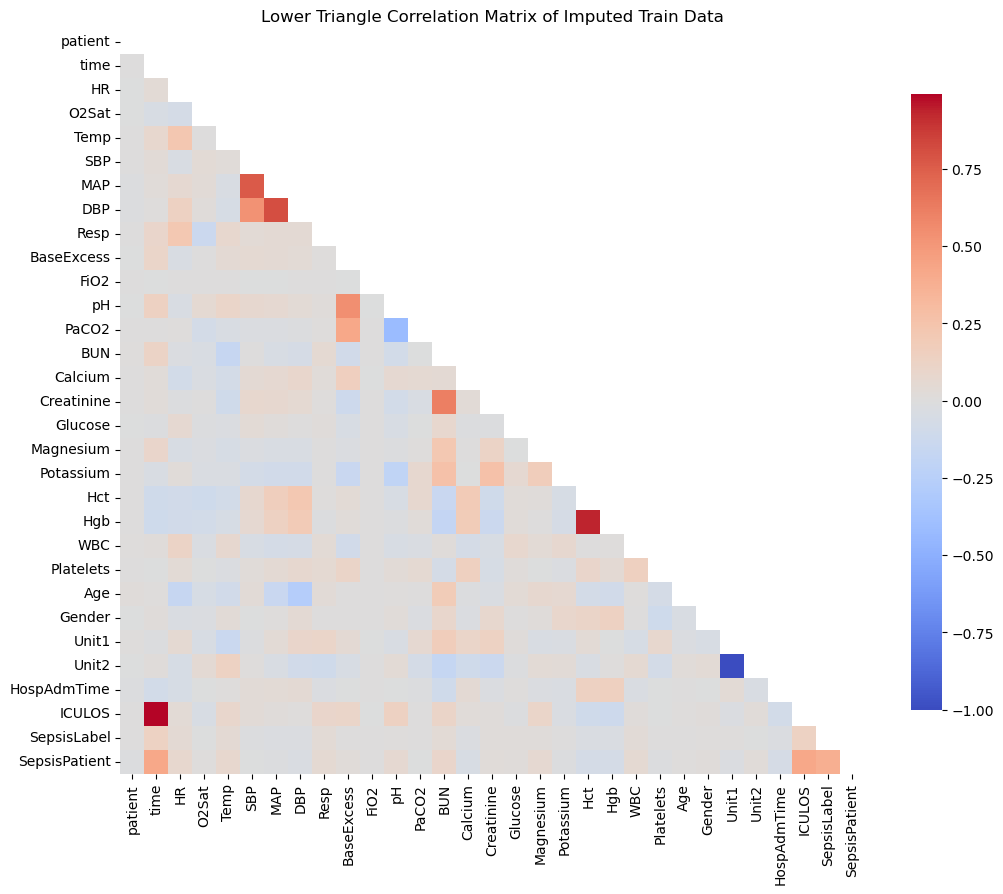

In [29]:
correlation_matrix = imputed_data.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Imputed Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

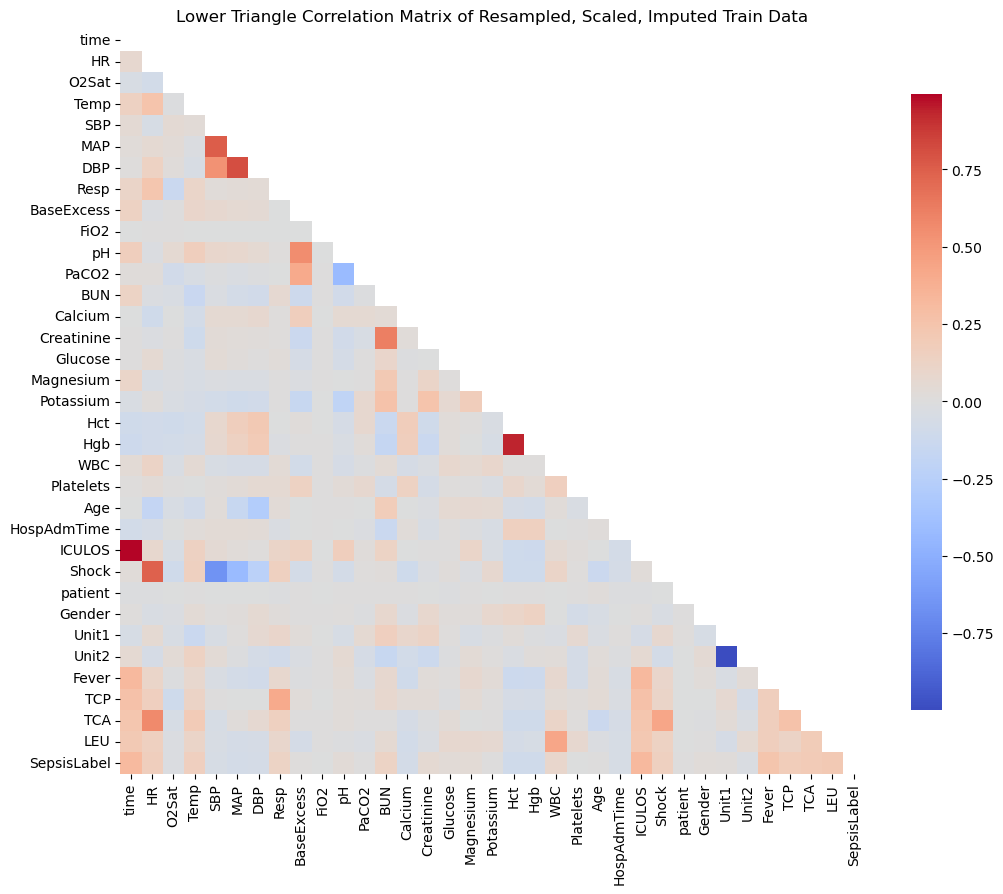

In [30]:
correlation_matrix = scaled_train.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Resampled, Scaled, Imputed Train Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

## Distributions for train data set pipeline

In [31]:
def plot_all_variable_distributions(df):
    """
    Plots the distribution of all numerical variables in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): The DataFrame containing the data.
    """
    
    num_cols = df.select_dtypes(include=['float64', 'int64']).columns
    
    
    num_vars = len(num_cols)
    plt.figure(figsize=(15, 5 * num_vars))
    
    for i, col in enumerate(num_cols):
        plt.subplot(num_vars, 1, i + 1)  
        sns.histplot(df[col], kde=True, bins=30, color='blue')  
        plt.title(f'Distribution of {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        
    plt.tight_layout()  
    plt.show()


#plot_all_variable_distributions(train_data)

In [32]:
#plot_all_variable_distributions(resampled_train)

## Final train data set to csv

In [33]:
# TODO : eliminate index columnt that is applied?
scaled_train.to_csv(missForestTrainFile)

# TEST PIPELINE

## Imputing B/F and missforest

In [34]:
test_dropped = test_data.drop(cols_to_drop_for_missing_percentage, axis = 1)
test_dropped.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,NaN,101.0,69.67,NaN,NaN,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,NaN,125.0,75.67,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,NaN,150.0,94.67,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,6.0


In [35]:
#forward imputation
test_forward = forward_fill_by_patient(test_dropped)
test_forward.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,NaN,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,37.67,101.0,69.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,37.67,125.0,75.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,37.67,150.0,94.67,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,16.0,NaN,...,27.4,NaN,NaN,NaN,81.64,1.0,1.0,0.0,-0.03,6.0


In [36]:
#forward imputation
pre_imputed_test = backward_fill_by_patient(test_forward)
pre_imputed_test.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Hct,Hgb,WBC,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS
0,6560,1,110.0,98.0,37.67,124.0,78.00,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,2.0
1,6560,2,103.0,96.0,37.67,101.0,69.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,3.0
2,6560,3,105.0,96.0,37.67,125.0,75.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,4.0
3,6560,4,118.0,94.0,37.67,150.0,94.67,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,5.0
4,6560,5,99.0,94.0,37.50,98.0,64.00,NaN,16.0,NaN,...,27.4,9.0,7.3,127.0,81.64,1.0,1.0,0.0,-0.03,6.0


## Find number of missing pre-imputation

In [37]:
naPercentagesTest = pd.DataFrame(pre_imputed_test.isna().sum() / pre_imputed_test.shape[0], columns=['Percentage Test'])
naPercentagesAll = pd.concat([naPercentages, naPercentagesTest], axis = 1)
naPercentagesAll.sort_values(by = ['Percentage Test'], ascending=False).head(10)

,Percentage,Percentage Test
BaseExcess,0.637390,0.636676
FiO2,0.501017,0.504755
PaCO2,0.485635,0.493645
pH,0.471871,0.479554
Unit2,0.391502,0.400408
Unit1,0.391502,0.400408
DBP,0.166844,0.167310
Calcium,0.096244,0.101265
Magnesium,0.087443,0.088816
WBC,0.041200,0.044761


In [ ]:
# forward fill 
pre_imputed_test['HR'] = pd.to_numeric(pre_imputed_test['HR'], errors='coerce')

imputed_test = imputer.transform(pre_imputed_test)

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [02:37<01:43, 51.67s/it]

In [ ]:
imputed_test.isna().sum()

patient        0
time           0
HR             0
O2Sat          0
Temp           0
SBP            0
MAP            0
DBP            0
Resp           0
BaseExcess     0
FiO2           0
pH             0
PaCO2          0
BUN            0
Calcium        0
Creatinine     0
Glucose        0
Magnesium      0
Potassium      0
Hct            0
Hgb            0
WBC            0
Platelets      0
Age            0
Gender         0
Unit1          0
Unit2          0
HospAdmTime    0
ICULOS         0
dtype: int64

In [ ]:
featured_validate = FeatureEngineering(validate_split_data)
featured_test = FeatureEngineering(imputed_test)

In [ ]:
featured_validate.head()

,patient,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,...,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel,Shock,Fever,TCA,TCP,LEU
366,20745,1,114.0,99.0,38.83,132.0,97.0,76.0,19.0,-8.0,...,0.00004,0.99996,-0.03,8.0,0.0,0.863636,1,1,0,1
367,20745,2,111.0,98.0,37.67,120.0,89.0,69.0,18.0,-8.0,...,0.00004,0.99996,-0.03,9.0,0.0,0.925000,1,1,0,1
368,20745,3,100.0,99.5,37.67,108.0,82.0,64.5,17.0,-8.0,...,0.00004,0.99996,-0.03,10.0,0.0,0.925926,1,1,0,1
369,20745,4,98.0,99.0,36.83,103.0,78.0,61.0,16.5,-8.0,...,0.00004,0.99996,-0.03,11.0,0.0,0.951456,1,1,0,1
370,20745,5,97.0,100.0,36.83,99.0,76.0,59.0,17.0,-8.0,...,0.00004,0.99996,-0.03,12.0,0.0,0.979798,1,1,0,1


## Scaling

In [ ]:
# Separate columns into those to scale and those to exclude (no target variable in test)
cols_to_scale_test = featured_test.drop(columns=exclude_scaling_cols).columns
cols_to_scale_val = featured_validate.drop(columns=exclude_scaling_cols + ['SepsisLabel']).columns

# Scale the selected columns using the already-fitted scaler
scaled_test_data = pd.DataFrame(scaler.transform(imputed_test[cols_to_scale_test]), columns=cols_to_scale_test)
scaled_val_data = pd.DataFrame(scaler.transform(validate_split_data[cols_to_scale_test]), columns=cols_to_scale_val)


# Combine scaled data with excluded columns
scaled_test = pd.concat([scaled_test_data, featured_test[exclude_scaling_cols]], axis=1)
scaled_val = pd.concat(
    [scaled_val_data, 
     featured_validate[exclude_scaling_cols + ['SepsisLabel']].reset_index(drop=True)],
    axis=1
)

In [ ]:
scaled_val.head()

,time,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,BaseExcess,FiO2,...,Shock,patient,Gender,Unit1,Unit2,Fever,TCP,TCA,LEU,SepsisLabel
0,-0.788213,1.548025,0.607817,2.361418,0.388925,0.923011,0.942963,-0.013593,-2.515884,-0.013695,...,-0.000913,20745,1.0,0.00004,0.99996,1,0,1,1,0.0
1,-0.764708,1.382141,0.284764,0.919362,-0.123300,0.429731,0.423856,-0.197292,-2.515884,-0.013695,...,-0.000913,20745,1.0,0.00004,0.99996,1,0,1,1,0.0
2,-0.741204,0.773901,0.769343,0.919362,-0.635525,-0.001889,0.090144,-0.380992,-2.515884,-0.013695,...,-0.000913,20745,1.0,0.00004,0.99996,1,0,1,1,0.0
3,-0.717699,0.663312,0.607817,-0.124885,-0.848953,-0.248529,-0.169409,-0.472842,-2.515884,-0.013695,...,-0.000913,20745,1.0,0.00004,0.99996,1,0,1,1,0.0
4,-0.694194,0.608017,0.930870,-0.124885,-1.019695,-0.371849,-0.317725,-0.380992,-2.515884,-0.013695,...,-0.000913,20745,1.0,0.00004,0.99996,1,0,1,1,0.0


## Correlation matrixes for test data set pipeline

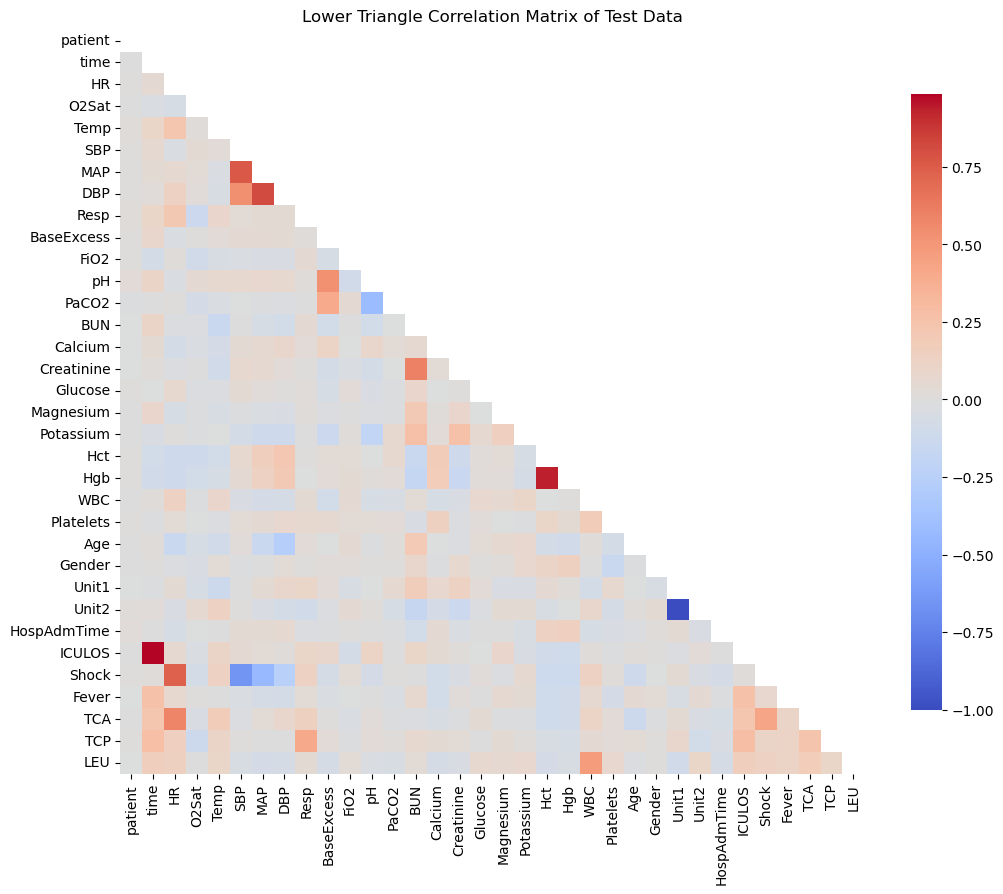

In [ ]:
correlation_matrix = imputed_test.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Test Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

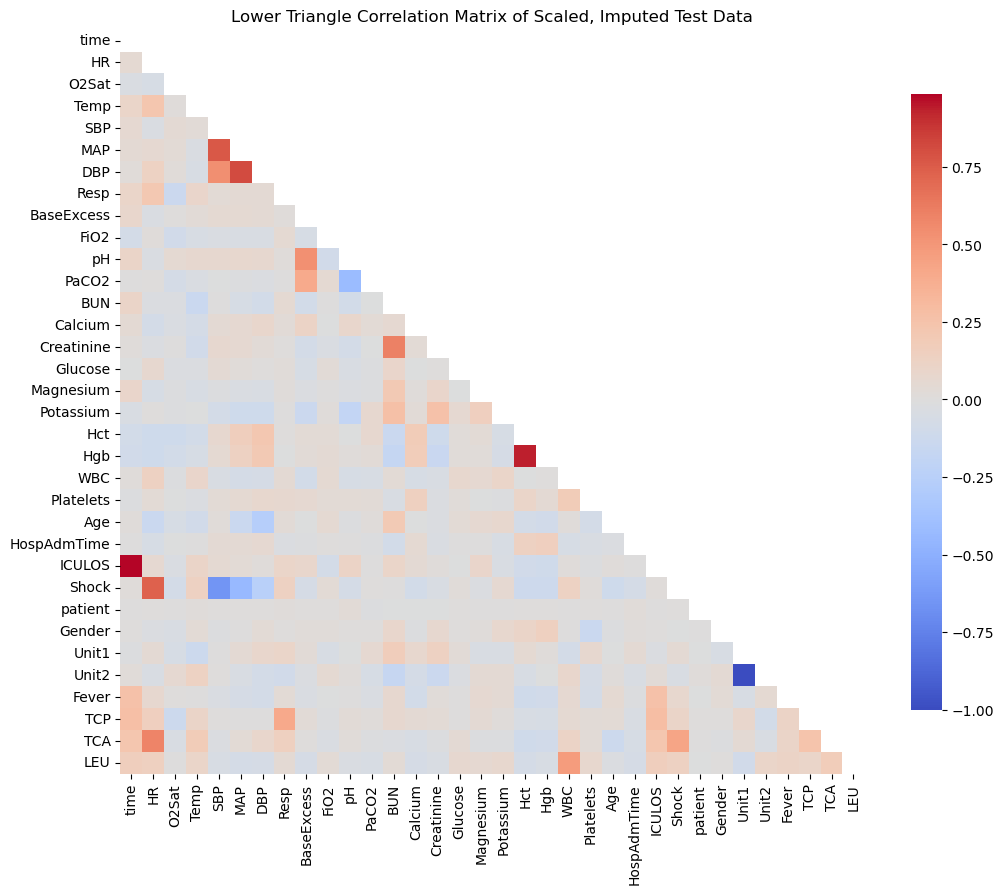

In [ ]:
correlation_matrix = scaled_test.corr()

# Mask the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap of the correlation matrix, masking the upper triangle
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', square=True, mask=mask, cbar_kws={"shrink": .8})

# Set the title
plt.title('Lower Triangle Correlation Matrix of Scaled, Imputed Test Data')
plt.savefig('Plots/corrmat_train_imputed.png')
plt.show()

## Distributions for test data pipeline

In [ ]:
#plot_all_variable_distributions(scaled_test)

## Final test data set to csv 

In [ ]:
#get rid of the index
scaled_test.to_csv(missForestTestFile)
scaled_val.to_csv(validationFile)